# 프로젝트

**프로젝트 제출 루브릭**

| 평가 기준 | 달성 여부 및 설명 |
|-----------|--------------------|
| Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다. | 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다. |
| CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다. | 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다. |
| keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.| 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다. |

## 목차 및 1차 회고록
1. **데이터셋 로드 및 시각화**
2. **CRNN 모델 초기화**
3. **모델 학습 (Training)**
4. **학습 결과 시각화 (Loss, Accuracy, Edit Distance)**
5. **모델 추론 테스트 (Inference)**
6. **EasyOCR을 이용한 텍스트 검출 및 CRNN 인식 (End-to-End)**

---

## 1. 데이터 병목현상 해결 (Data Bottleneck)

> **Issue:** `DataLoader`에서 배치 단위로 데이터를 불러올 때 비정상적으로 긴 시간이 소요됨.  
> **Diagnosis:** `MJDataset`의 초기화 코드 내 `LMDB` 연결 방식 문제.

사실 왠지 몰랐음. 팀원분들의 얘기를 들어보며 shuffle과 직렬화로 인해 문제가 있는거 같기도 하고 하다가...
그냥 Colab 사용하면서 Gemini랑 얘기하다보니 아래 문제가 발생하였다고 함. 수정하니 정상진행 됨.

### 원인 및 해결
**[원인]**
기존 코드에서는 `__init__` 시점에 LMDB 연결(`self.env`)을 생성하여 메인 프로세스와 워커 프로세스가 동일한 연결 객체를 공유하려 했습니다. 이로 인해 `DataLoader`가 멀티프로세싱을 위해 데이터를 복제(Pickling)하는 과정에서 **OS 파일 핸들 충돌 및 락(Lock) 경합**이 발생하여 심각한 병목 현상을 초래했습니다.

**[해결]**
이를 해결하기 위해, `__init__`에서는 데이터 개수만 파악 후 연결을 닫고, 실제 데이터 로드 시점인 `__getitem__`에서 연결이 없을 경우에만 생성하도록 하는 **지연 초기화(Lazy Initialization)** 방식을 적용했습니다. 이를 통해 각 워커 프로세스가 독립적인 LMDB 연결을 갖게 되어 병목을 제거했습니다.

---

## 2. 학습 시간 및 데이터 비율 선정 (Training Time Estimation)

병목 현상 해결 후, 환경별 학습 예상 시간을 계산하여 효율적인 데이터 비율을 선정함.

### Case 1: Google Colab (Drive Mount)
* **Total Data:** 56,442 batches (Batch_size=128)
* **Speed:** 0.7s / batch
* **Time (1 Epoch, 100%):** $0.7 \times 56442 \approx 39,509s$ (**최소 10시간 이상**)
* **Estimation with Ratio:**
    * Ratio 5%: 약 34분
    * Ratio 1%: 대략 7분

물론 Colab도 Drive가 아니라 단순 colab local disk에 저장하면 좀 더 빨라지겠지만...   
이번건 LMS에서도 큰 배치로도 빠르게 돌아가기에, colab 유료 할당량을 아끼기 위해 패스함
(유료 할당량 알지 못하고, A100 막 쓰다가 일주일도 못가서 한달 할당량 절반을 씀...)

### Case 2: LMS Local Environment
* **Speed:** 0.18s / batch (Colab 대비 약 4배 빠름)
* **Time (1 Epoch, 100%):** $0.18 \times 56442 \approx 10,159s$ (**최소 2시간 48분**)
* **Estimation with Ratio:**
    * Ratio 5%: **최소 6분**
    * Ratio 1%: **최소 1분**

> **Conclusion:** 데이터의 양을 **5% 또는 10%로 타협**보고 진행할 것.

---

## 3. Data Augmentation 전략

데이터의 일부만 사용할 예정이기에, Augmentation을 약하게 주어 모델 난이도를 조정함.

* **Applied:**
    * `Rotate`
    * `GaussianBlur`
    * `ColorJitter`
        * 현실에서 어느정도 일어날법하게 약하게 조정함
        * 근데 증강 안해도 일부 이미지는 알아보기 힘들정도로 어둡긴 함...
* **Discarded:** `MotionBlur`, `GaussNoise`
    * *Reason:* 증강된 이미지 시각화를 해보면 약하게 줘도 내 눈에도 보기 힘든 이미지가 생성되다 보니 제거하고 진행함.

---

## 4. 평가 지표 선정 (Evaluation Metrics)

앞서 베이스라인 코드에서는 Loss만 존재했음. 정량적 평가를 위해 특정 Metric을 선정하고자 함.

### Metrics
1.  **Accuracy**
    * 예측한 텍스트와 정답 레이블이 **완전히 일치**하는지 확인.
2.  **Edit Distance (Levenshtein Distance)**
    * 예측값과 정답 간의 **유사도**를 측정하기 위한 지표.
    * 정답 문자열로 변환하기 위해 필요한 문자의 **삽입, 삭제, 변경 횟수**를 계산 (0에 가까울수록 좋음).

### Selection Rationale
단순 Acc 외에 다른 Metric이 있나 고민했음. (글자인식 문제다보니 예를들어 다 맞는데 틀린 글자가 하나 포함되어있다거나, 한 글자만 빠져있다거나 등의 상황에서 어떻게 지표를 만들어야 할지 고민이었음).   
여러 논문에서 **Edit Distance**라는 단어가 있었고, 이걸로 진행해봄. (편집 횟수를 계산하여 유사도를 측정한다는 개념이 끌렸음.)

## 2차 회고록

- 5% 데이터만 사용
- AdaDelta 사용
- Augmentation 사용
- 그 외 하이퍼파라미터 노드에서 쓰던 default 사용

| Epoch | Train Loss | Val Loss | Train Acc (%) | Val Acc (%) | Train Dist | Val Dist | 비고 (Model Saved) |
|-------|------------|----------|----------------|--------------|------------|----------|---------------------|
| 1     | 2.9638     | 1.6505   | 0.03%          | 3.04%        | 7.6518     | 4.5068   | ✅ Saved            |
| 2     | 0.5689     | 0.4233   | 54.49%         | 59.05%       | 1.3642     | 1.0215   | ✅ Saved            |
| 3     | 0.2724     | 0.2491   | 74.34%         | 75.76%       | 0.6547     | 0.6044   | ✅ Saved            |
| 4     | 0.2131     | 0.2858   | 79.09%         | 72.86%       | 0.5215     | 0.6926   | -                   |
| 5     | 0.2296     | 0.2362   | 77.05%         | 77.00%       | 0.5960     | 0.5918   | ✅ Saved            |
| 6     | 0.2294     | 0.2366   | 77.12%         | 76.99%       | 0.5961     | 0.5919   | -                   |
| 7     | 0.2294     | 0.2364   | 77.11%         | 77.01%       | 0.5951     | 0.5920   | -                   |
| 8     | 0.2295     | 0.2369   | 77.05%         | 76.96%       | 0.5963     | 0.5931   | -                   |
| 9     | 0.2294     | 0.2366   | 77.11%         | 77.01%       | 0.5954     | 0.5920   | -                   |
| 10    | 0.2298     | 0.2360   | 77.05%         | 77.05%       | 0.5973     | 0.5902   | ✅ Best Saved       |

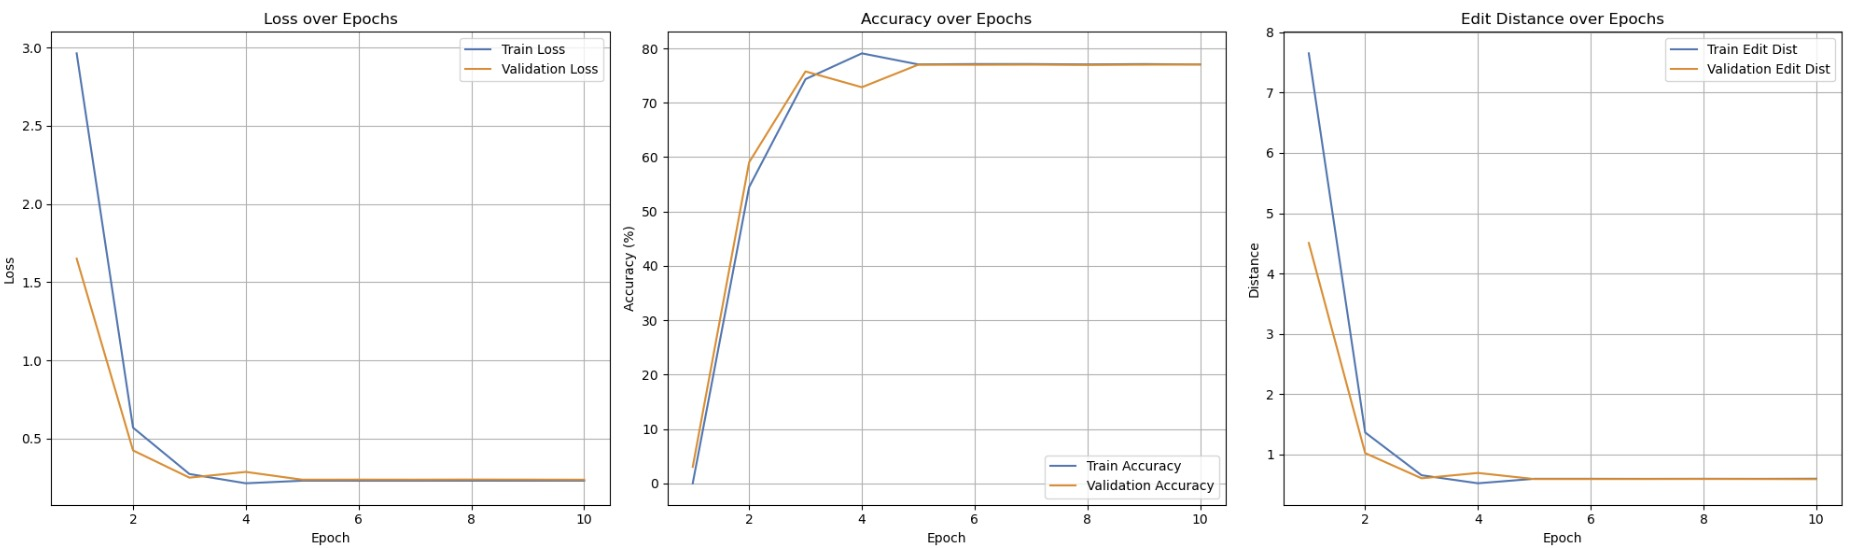

- 초기 빠른 학습(1~3 Epoch): Loss 급감, 정확도 75%까지 빠르게 상승.   
- 일시적 불안정(4 Epoch): Train 오르고, Valid 낮아지며 가벼운 과적합 징후 발생.   
- 수렴(5~10 Epoch): 정확도 약 77%, Edit Distance 0.59 수준에서 안정적으로 수렴.   
- 최종 성능: Epoch 10에서 최고 정확도·최저 Loss, Best Model 저장.   

# 3차 회고록
- augmentation 사용
- 10% 데이터 사용
- 해상도를 데이터의 평균치에 맞게 조정
- Adam으로 변경

| Epoch | Train Loss | Val Loss | Train Acc (%) | Val Acc (%) | Train Dist | Val Dist | 비고 (Model Saved)       |
|-------|------------|----------|----------------|--------------|------------|----------|-------------------------|
| 1     | 2.5910     | 0.5992   | 6.33%          | 45.77%       | 6.3465     | 1.4535   | ✅ Saved                |
| 2     | 0.3177     | 0.2509   | 65.50%         | 69.99%       | 0.8432     | 0.6848   | ✅ Saved                |
| 3     | 0.2094     | 0.1989   | 75.03%         | 76.26%       | 0.5794     | 0.5519   | ✅ Saved                |
| 4     | 0.1745     | 0.1762   | 79.87%         | 80.62%       | 0.4740     | 0.4578   | ✅ Saved                |
| 5     | 0.1541     | 0.1534   | 82.72%         | 83.46%       | 0.4136     | 0.3958   | ✅ Saved                |
| 6     | 0.1393     | 0.1384   | 84.57%         | 84.42%       | 0.3720     | 0.3691   | ✅ Saved                |
| 7     | 0.1273     | 0.1370   | 85.83%         | 84.88%       | 0.3410     | 0.3601   | ✅ Saved                |
| 8     | 0.1206     | 0.1309   | 86.59%         | 86.03%       | 0.3235     | 0.3414   | ✅ Saved                |
| 9     | 0.1111     | 0.1325   | 87.64%         | 86.42%       | 0.3002     | 0.3293   | -                       |
| 10    | 0.1055     | 0.1251   | 88.20%         | 86.92%       | 0.2860     | 0.3192   | ✅ Saved                |
| 11    | 0.0980     | 0.1231   | 88.93%         | 87.14%       | 0.2708     | 0.3144   | 🔄 Resume & Saved       |
| 12    | 0.0982     | 0.1229   | 88.95%         | 87.17%       | 0.2710     | 0.3140   | ✅ Best Saved           |
| 13    | 0.0981     | 0.1231   | 88.96%         | 87.17%       | 0.2707     | 0.3137   | -                       |
| 14    | 0.0984     | 0.1231   | 88.93%         | 87.14%       | 0.2712     | 0.3138   | -                       |
| 15    | 0.0980     | 0.1230   | 88.94%         | 87.13%       | 0.2706     | 0.3146   | -                       |

- 마찬가지로 3epoch까지 빠르게 학습. loss 급감함
- 그래서 좀 더 자세히 보기 위해 3epoch부터 시각화로 다시 관찰
- Loss는 6epoch까지 비슷하게 떨어짐
    - 다만 train은 계속해서 가파르게 11 epoch까지 떨어지다가 0.98에서 거의 수렴
    - valid는 6epoch에서 기울기가 낮아지며 천천히 감소하다가, 11epoch부터 0.12에 거의 수렴
- Acc도 6epoch까지 비슷하게 오르다가 train과 valid가 반점됨
    - train은 그대로 더 올라가다가 11epoch부터 88.9에서 거의 수렴
    - valid는 6epoch에서 train과 반전되더니, 천천히 오르다가, 마찬가지로 11epoch에서 87.1에서 멈춤
- ED도 Acc처럼 비슷한 양상을 띄움. 6epoch까지는 급감하다가 train과 valid가 반전됨
    - train은 더 떨어지다가 11epoch에서 0.27에서 머뭄
    - valid는 6epoch부터 train에 점수가 반전이 되었고, 11epoch에서 0.31에서 머뭄

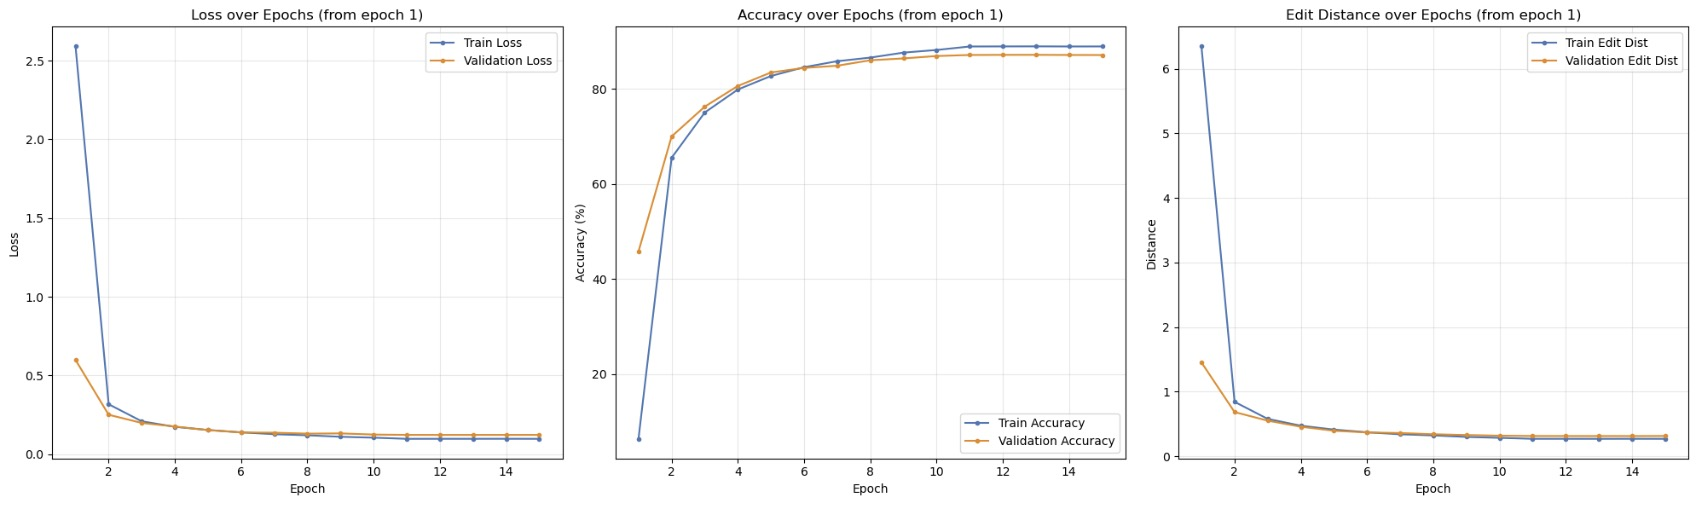
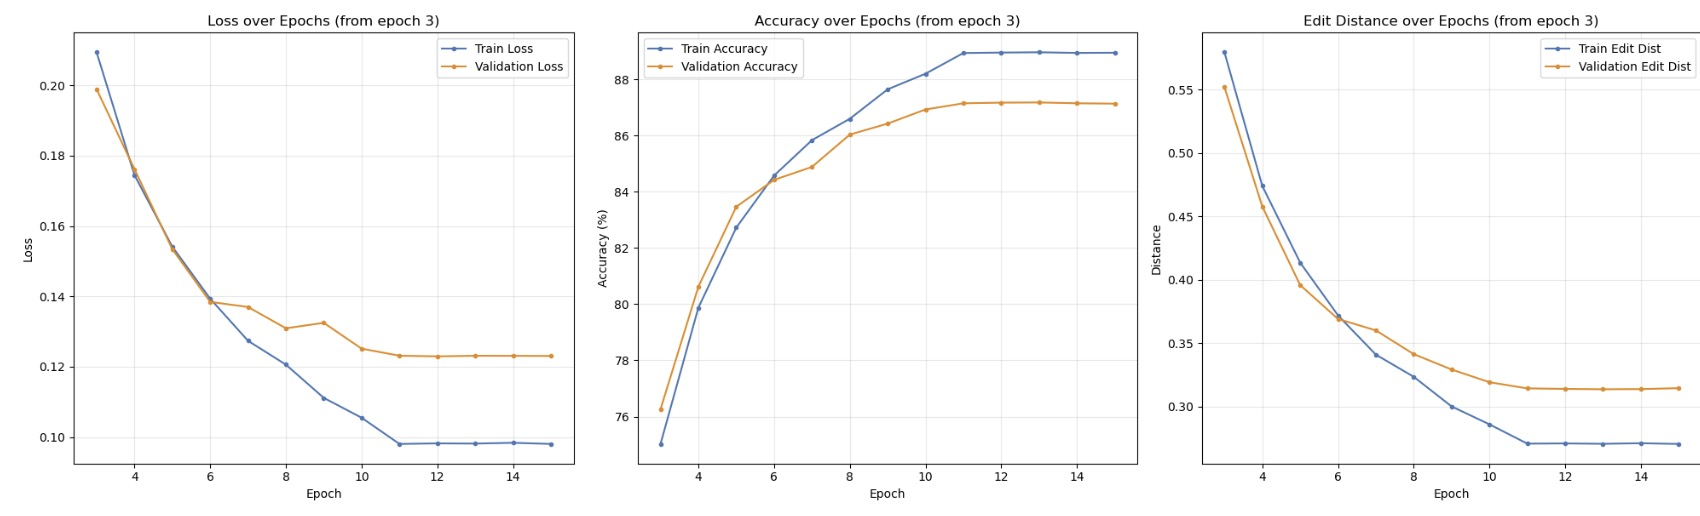


이제 글자 개수는 동일하게 출력된다.  
선명한 이미지에 대해서는 잘 출력한다.  
다만 사람 눈으로도 약간 흐릿하거나 잘 구분이 안되는 이미지는 모델 역시 일정 글자를 잘못 출력한다. (이 부분에 대해서 고민을 해봐야할 거 같다.)  
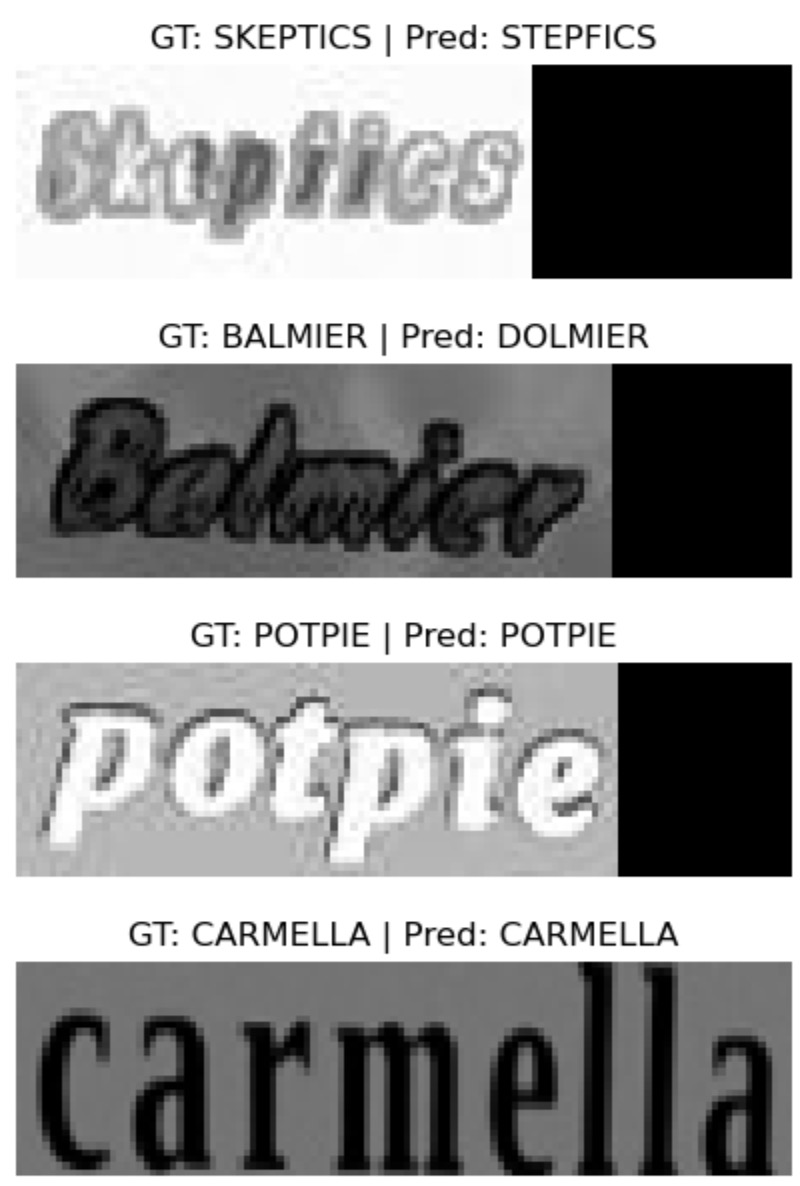

# 4차 회고록
- 10% 데이터 사용
- 해상도를 데이터의 평균치에 맞게 조정
- Adam으로 변경
- aug를 제거한다. (퍼실님이 해당 모델과 task에서 MJ 데이터양이 굳이 필요하지 않을수도 있으며, 그에따라 aug가 필요하지 않아도 될 수 있다는 말에 한 번 돌려본다.

아무래도 aug 없이 돌리게 되면, 위 2,3차 회고록에서 초반 epoch에서 보이던 valid가 train보다 성능(점수)가 높게 나오는 현상은 아마 보이지 않을 거 같다. (돌리기 전 예상)

| Epoch | Train Loss | Val Loss | Train Acc (%) | Val Acc (%) | Train Dist | Val Dist | 비고 (Model Saved) |
|-------|------------|----------|----------------|--------------|------------|----------|---------------------|
| 1     | 2.1633     | 0.3926   | 16.88%         | 59.41%       | 5.3258     | 1.0038   | ✅ Saved            |
| 2     | 0.2472     | 0.2209   | 68.27%         | 69.65%       | 0.7074     | 0.6646   | ✅ Saved            |
| 3     | 0.1765     | 0.1797   | 73.97%         | 71.86%       | 0.5401     | 0.5738   | ✅ Saved            |
| 4     | 0.1496     | 0.1573   | 76.08%         | 75.80%       | 0.4791     | 0.4903   | ✅ Saved            |
| 5     | 0.1332     | 0.1511   | 78.76%         | 78.60%       | 0.4264     | 0.4522   | ✅ Saved            |
| 6     | 0.1212     | 0.1479   | 80.72%         | 78.64%       | 0.3898     | 0.4433   | ✅ Saved            |
| 7     | 0.1125     | 0.1352   | 81.99%         | 81.81%       | 0.3630     | 0.3953   | ✅ Saved            |
| 8     | 0.1049     | 0.1299   | 83.50%         | 81.53%       | 0.3362     | 0.3908   | ✅ Saved            |
| 9     | 0.0990     | 0.1259   | 84.22%         | 83.46%       | 0.3220     | 0.3667   | ✅ Saved            |
| 10    | 0.0946     | 0.1268   | 84.90%         | 84.01%       | 0.3090     | 0.3572   | -                   |
| 11    | 0.0909     | 0.1234   | 85.93%         | 84.45%       | 0.2941     | 0.3481   | ✅ Saved            |
| 12    | 0.0849     | 0.1210   | 86.26%         | 85.00%       | 0.2839     | 0.3382   | ✅ Saved            |
| 13    | 0.0807     | 0.1211   | 87.01%         | 83.52%       | 0.2699     | 0.3590   | -                   |
| 14    | 0.0800     | 0.1206   | 87.35%         | 84.58%       | 0.2666     | 0.3434   | ✅ Best Saved       |
| 15    | 0.0758     | 0.1226   | 87.56%         | 84.26%       | 0.2604     | 0.3510   | -                   |


- 마찬가지로 2epoch까지는 급감하거나 급등한다. 이때까지는 train보다 valid가 우세하다.
- 2epoch 이후로 다시 시각화를 자세히 보자
    - 3epoch를 기준으로 train이 valid의 점수를 역전시킨다.
    - 12epoch까지는 꾸준히 증가하거나 감소하는 경향을 보인다.
- 다만 valid는 12epoch부터 특정 수치에 머무는 경향이 포착
- 반대로 train은 꾸준히 증가하거나 감소하는 경향이 보여, 15epoch만으로 수렴되었다라고 보기 힘듬

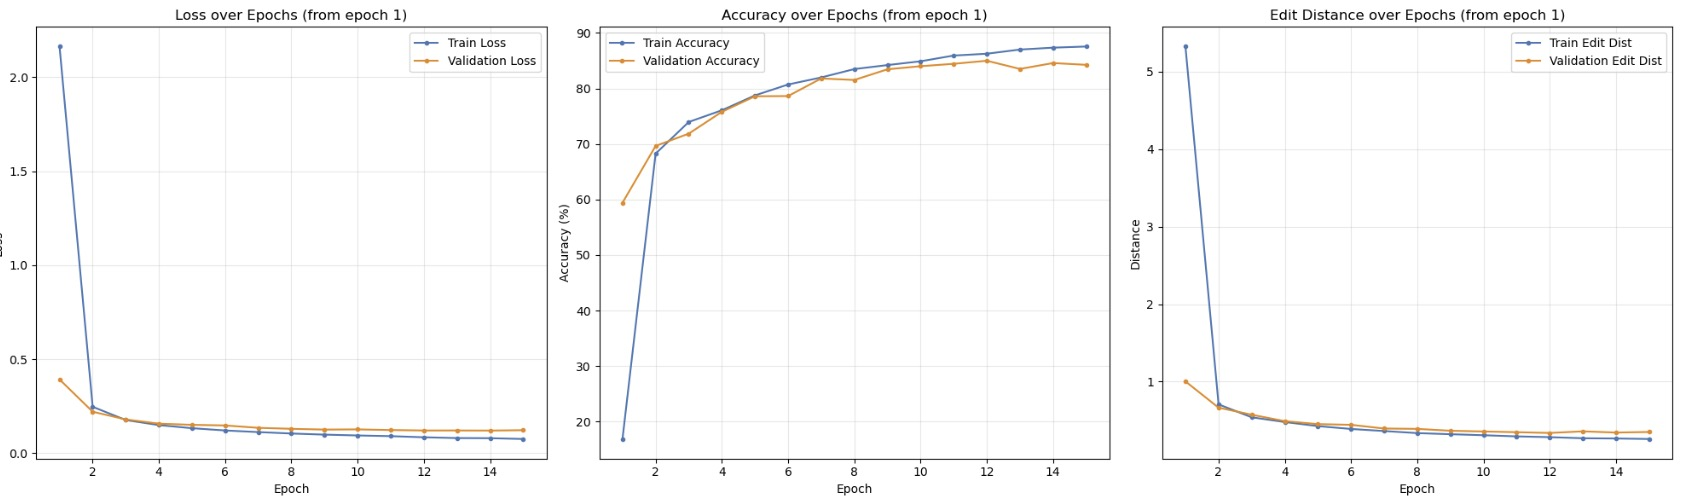
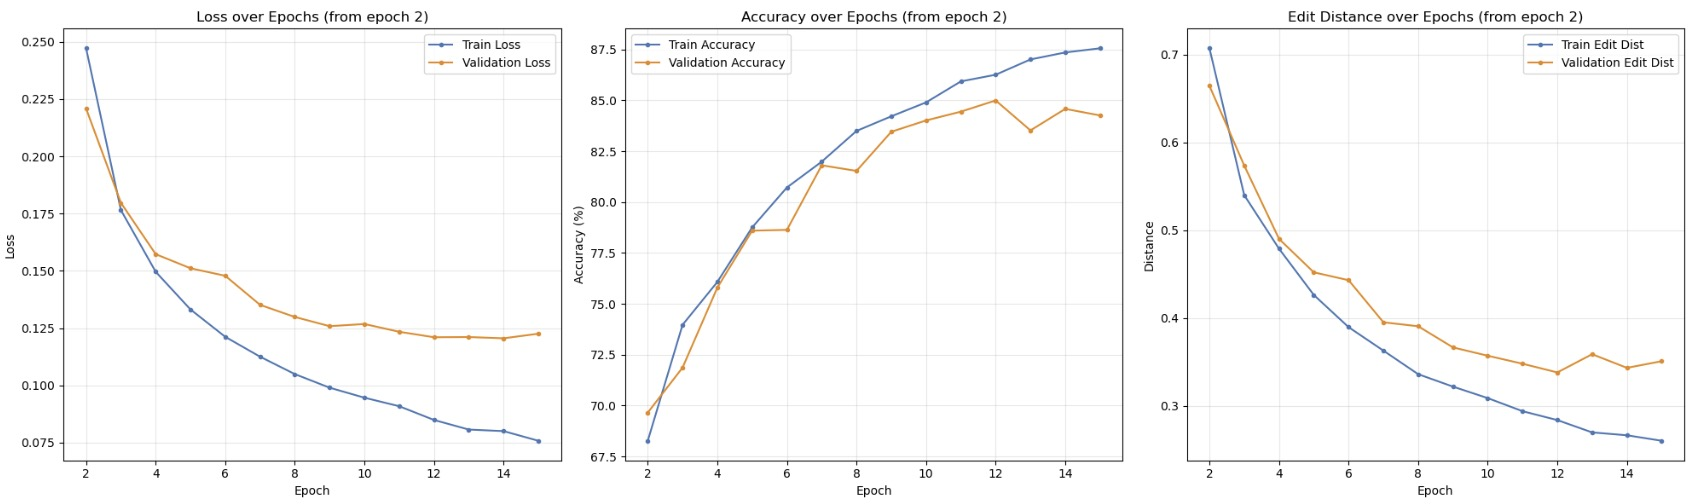

=== Test Result === -> aug 없는 4차 회고록  
Total samples   : 89192  
Accuracy        : 84.49% (75354/89192)  
Avg Edit Dist   : 0.343  
Avg CTC Loss    : 1.4119  
| Epoch | Train Loss | Val Loss | Train Acc (%) | Val Acc (%) | Train Dist | Val Dist | 비고 (Model Saved) |
|-------|------------|----------|----------------|--------------|------------|----------|---------------------|
|
| 14    | 0.0800     | 0.1206   | 87.35%         | 84.58%       | 0.2666     | 0.3434   | ✅ Best Saved  |

=== Test Result === -> aug 있는 3차 회고록  
Total samples   : 89192  
Accuracy        : 87.29% (77859/89192)  
Avg Edit Dist   : 0.311  
Avg CTC Loss    : 1.2641  

| Epoch | Train Loss | Val Loss | Train Acc (%) | Val Acc (%) | Train Dist | Val Dist | 비고 (Model Saved)       |
|-------|------------|----------|----------------|--------------|------------|----------|-------------------------|
| 12    | 0.0982     | 0.1229   | 88.95%         | 87.17%       | 0.2710     | 0.3140   | ✅ Best Saved   |

- best valid loss 기준 aug 없는 버전이 더 낮지만, metric면에서는 aug 있는 버전이 높은 수치를 보여준다.
- 이에 따라서 test dataset에 점수를 내보면, aug있는 버전이 loss와 metric 모두 aug없는 것보다 높은 수치를 보여준다.
- aug로 인해 10% 데이터에 대해서는 일반화에 도움이 된다라고 볼 수 도 있을 거 같다.

# 1. 데이터셋 로드 및 시각화

In [3]:
# !pip install torch torchvision opencv-python lmdb tqdm six easyocr python-Levenshtein albumentations

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
import lmdb
import six
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import albumentations as A
from IPython.display import display

# src폴더 내에 .py로 모듈화 해 둠.
# 이제부터 이렇게 함수 길어지면 깔끔하게 진행하고 github에 올리는 방향으로 진행할 것임.
# 처음이라 아직 깔끔하지 않을 것임
from src.dataset import MJDataset, collate_fn
from src.model import CRNN
from src.trainer import run_training
from src.utils import LabelConverter, TARGET_CHARACTERS, plot_training_metrics
from src.inference import check_inference, detect_text, recognize_img, test_model
from src.analysis import analyze_text_length_distribution, analyze_image_distribution, visualize_dataset_samples, visualize_augmented_samples

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
data_dir = os.path.join(os.getenv("HOME"),"work/project/GoingDeeper/Quest06")

print(f"data_dir: {data_dir}")

data_dir: /home/jovyan/work/project/GoingDeeper/Quest06


In [3]:
TRAIN_DATA_PATH = data_dir + '/data/MJ/MJ_train'
VALID_DATA_PATH = data_dir + '/data/MJ/MJ_valid'
TEST_DATA_PATH  = data_dir + '/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)
print(VALID_DATA_PATH)
print(TEST_DATA_PATH)

/home/jovyan/work/project/GoingDeeper/Quest06/data/MJ/MJ_train
/home/jovyan/work/project/GoingDeeper/Quest06/data/MJ/MJ_valid
/home/jovyan/work/project/GoingDeeper/Quest06/data/MJ/MJ_test


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


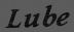

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


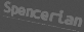

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


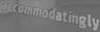

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


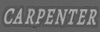

original image width:87, height:31
target_img_size:(89, 32)
display img shape:(89, 32, 3)
label:REGURGITATING


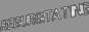

original image width:123, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:savannas


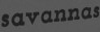

original image width:62, height:31
target_img_size:(64, 32)
display img shape:(64, 32, 3)
label:unfix


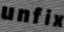

original image width:169, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CAGOULES


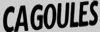

In [4]:
# Dataset Sample Visualization
visualize_dataset_samples(TRAIN_DATA_PATH, num_samples=8)

In [4]:
print(TARGET_CHARACTERS)
print(len(TARGET_CHARACTERS))
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
36
Encdoded_text:  [ 8  5 12 12 15]
Decoded_text:  HELLO


In [7]:
# # 텍스트 길이 분포 분석
# analyze_text_length_distribution(TRAIN_DATA_PATH, max_text_len=18)

# 왜 기본값을 18로 해두었는지 히스토그램과 평균을 봐봄
# 평균은 8, 최대는 23
# 음... 사실 이건 분석가 마음인거 같아보임
# 그냥 18로 둬도 상관은 없어보임. 굳이 한다면 4~15 사이로 그 밖은 샘플이 대비해서 적다보니

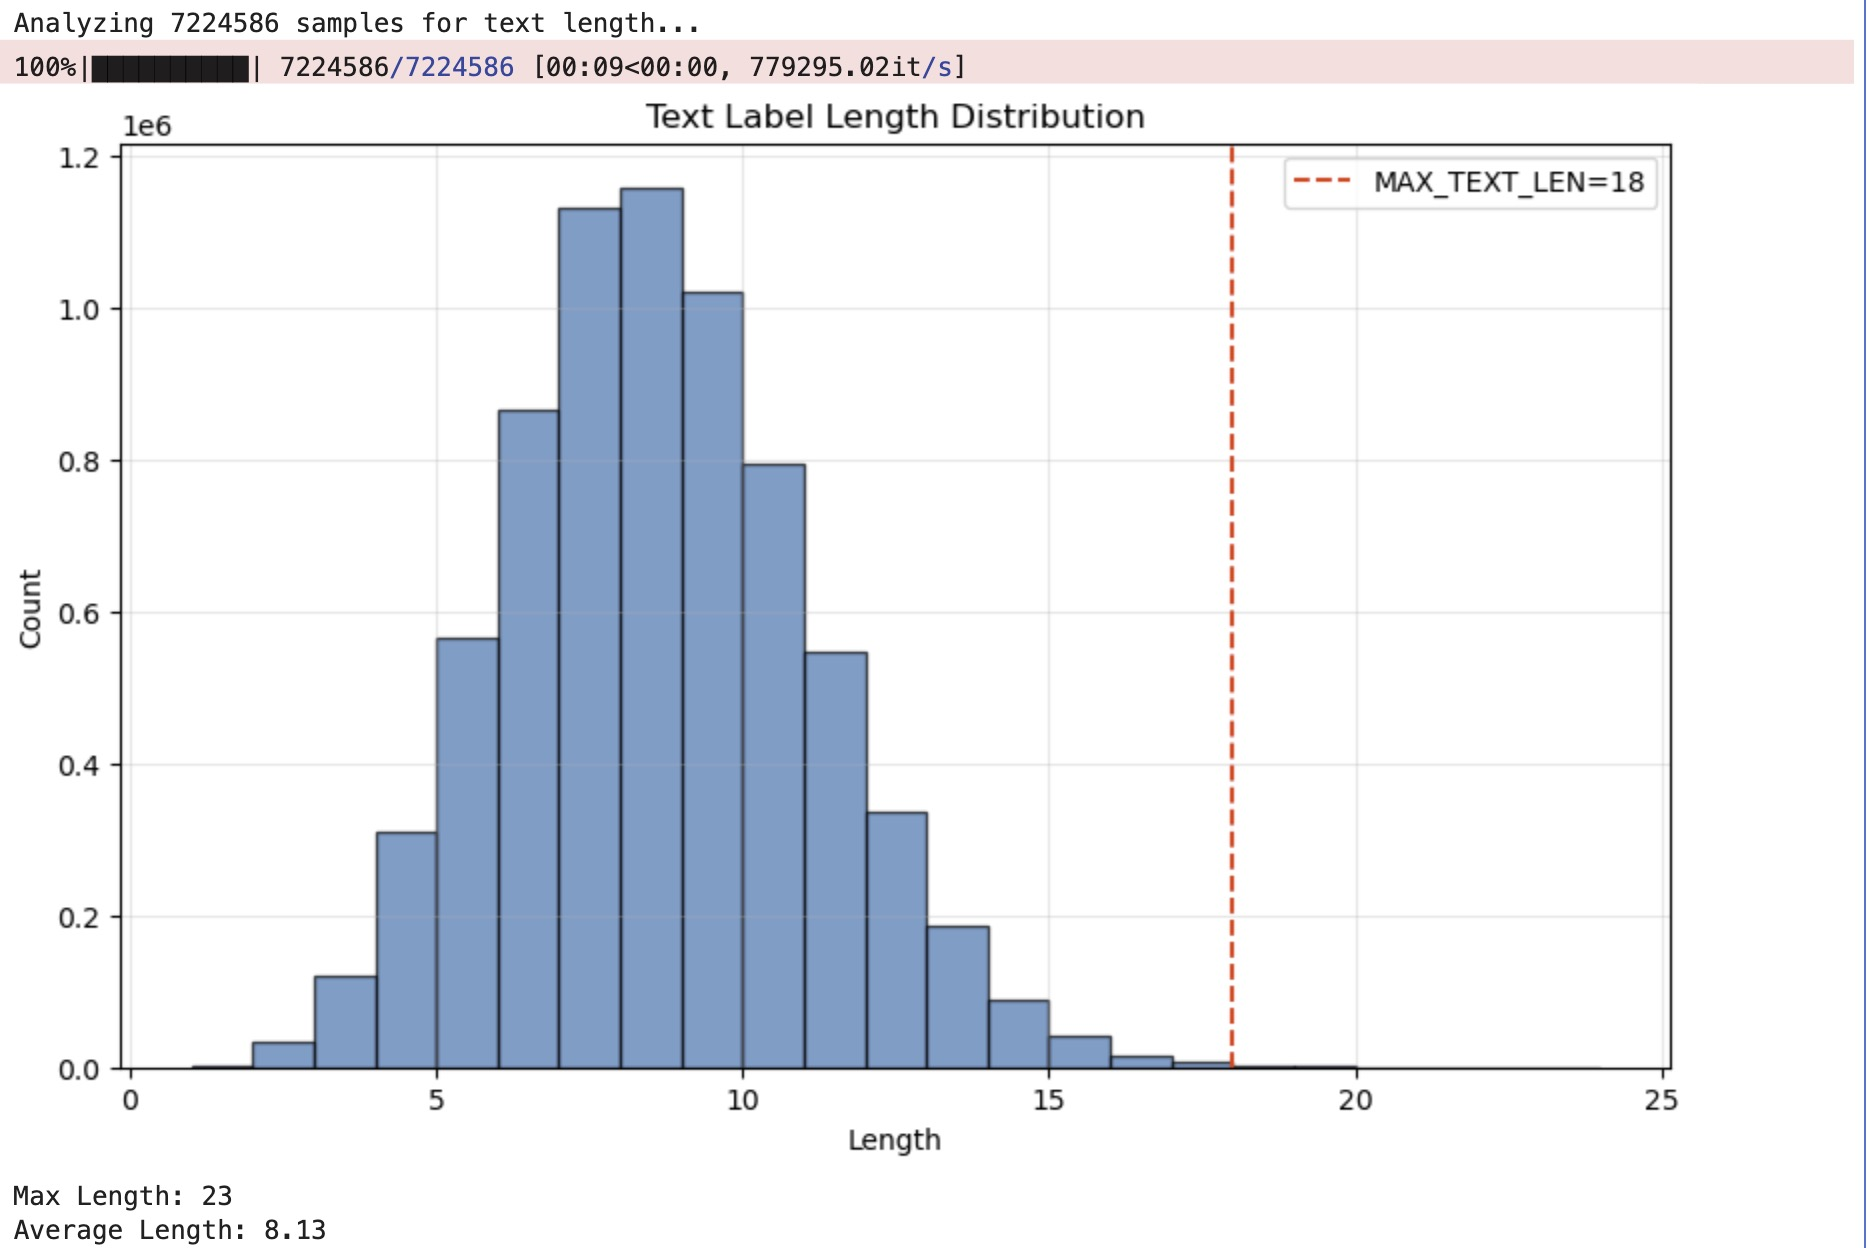

In [8]:
# # 이미지 해상도 및 종횡비 분포 분석
# analyze_image_distribution(TRAIN_DATA_PATH)

# 기본값이 (100, 32)로 되어있음
# 평균치 계산해보니 (116, 31)로 되어있음
# 기본값과 얼추 비슷함.
# (116,32)로 진행 -> 31은 모델 계산과정에서 출력 크기가 줄어들어 문제가 생김

계산과정이 너무 오래 걸리다 보니 결과 스크린샷해두고 코드는 주석처리

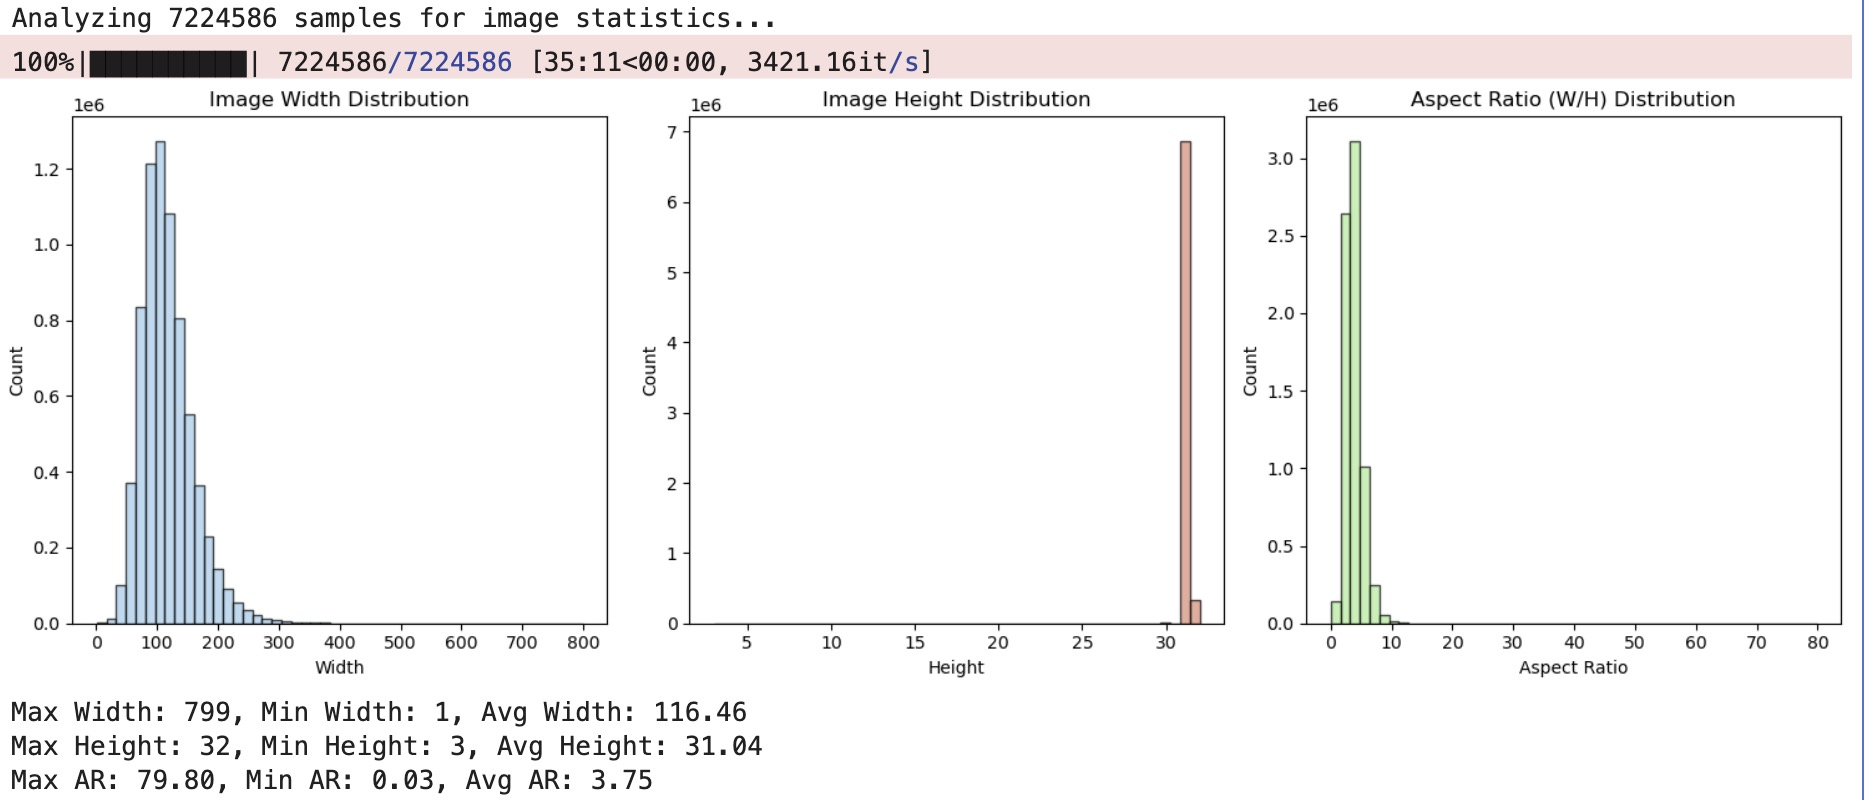

In [10]:
MAX_TEXT_LEN = 18
IMG_SIZE = (116, 32)
BATCH_SIZE = 128*2*2

# OCR Augmentation
# 텍스트 인식을 위해 강도를 약하게 조절함
# 데이터를 일부만 사용할거라서 데이터 증강으로 보완할 예정
# 다만 텍스트 인식에 방해가 될 수 있기에, 강도를 약하게 줄 예정
# 약하게 주려고 했음에도, 일부는 사람조차 보기 힘들어서 제거
train_aug = A.Compose([
    A.Rotate(limit=2, p=0.3),  # 이미지 회전(±3도 범위)로 기울기 변화 주기
    A.OneOf([
        A.GaussianBlur(blur_limit=(1,2), p=0.2),  # 가우시안 블러로 부드럽게 만들어 촬영 흐림 상황 모사
        # A.MotionBlur(blur_limit=3, p=0.5),    # 모션 블러로 움직임/흔들림 상황 모사
    ], p=0.3),
    A.ColorJitter(
        brightness=0.05, contrast=0.05, p=0.3 #, saturation=0.1, hue=0.03
    ),  # 밝기·대비·채도·색조를 약하게 변동하여 다양한 조명 조건 학습
    # A.GaussNoise(var_limit=(3, 10), p=0.2),  # 가우시안 노이즈 추가하여 센서 잡음 상황 모사
])

train_dataset = MJDataset(TRAIN_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,
                          character=TARGET_CHARACTERS, max_text_len=MAX_TEXT_LEN, ratio=0.1)
valid_dataset = MJDataset(VALID_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,
                          character=TARGET_CHARACTERS, max_text_len=MAX_TEXT_LEN, ratio=0.1)
test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,
                         character=TARGET_CHARACTERS, max_text_len=MAX_TEXT_LEN, ratio=0.1)

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,
                          num_workers=2,collate_fn=collate_fn,drop_last=False, pin_memory=True)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,
                          num_workers=2,collate_fn=collate_fn,drop_last=False, pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,
                         num_workers=0,collate_fn=collate_fn,drop_last=False, pin_memory=True)

print(f"\ntrain_loader: {len(train_loader)}")
print(f"valid_loader: {len(valid_loader)}")
print(f"test_loader: {len(test_loader)}")

Total 7224586 -> Used 722458 (10.0%)
Total 802731 -> Used 80273 (10.0%)
Total 891924 -> Used 89192 (10.0%)

train_loader: 1412
valid_loader: 157
test_loader: 175


Augmented Images Samples (Weak Augmentation Applied):


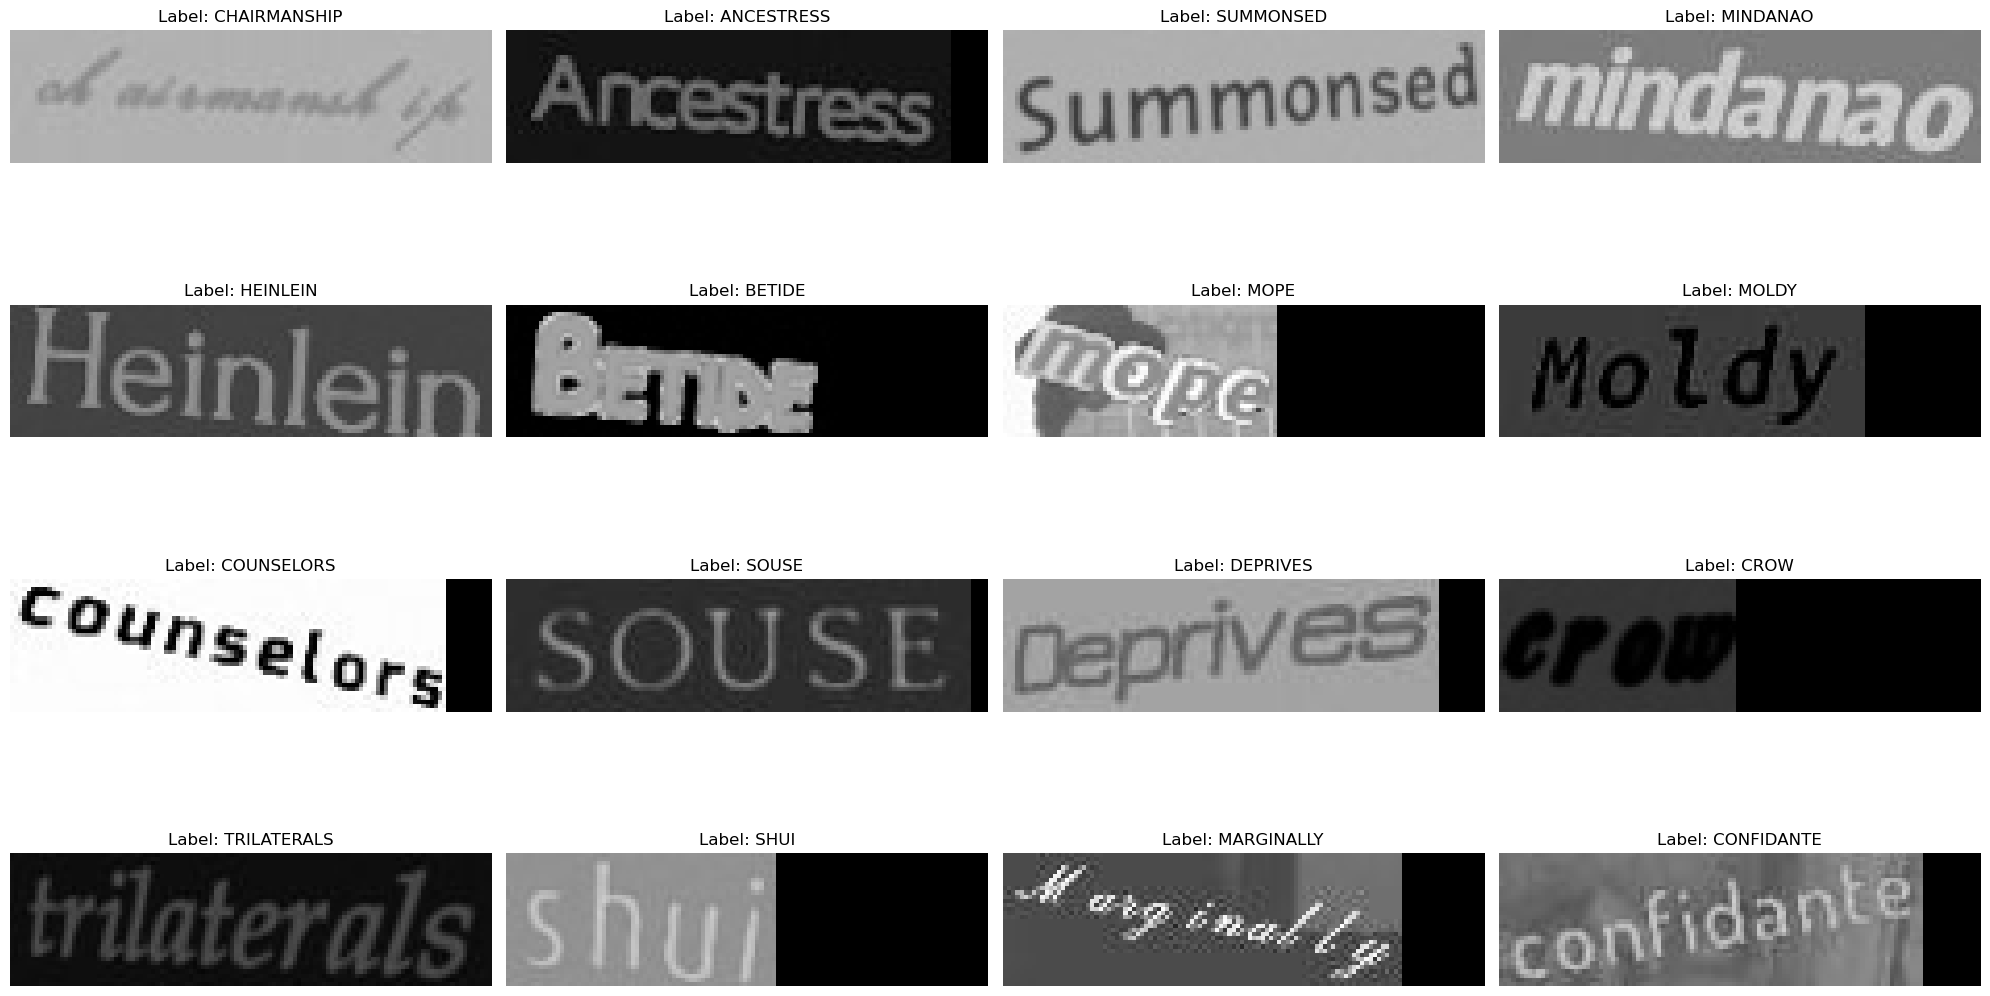

In [10]:
# Visualize Augmented Samples
visualize_augmented_samples(train_loader, num_samples=16)

# 2. CRNN 모델 초기화

In [15]:
# Model Setup
num_chars = len(label_converter.character)
model = CRNN(num_chars=num_chars).to(device)

criterion = nn.CTCLoss(zero_infinity=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
checkpoint_path = os.path.join(data_dir, "model/model_checkpoint.pth")
best_model_path = os.path.join(data_dir, "model/best_model.pth")

# Ensure model directory exists
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# 3. 모델 학습 (Training) 

In [1]:
model, train_losses, train_accs, train_dists, val_losses, val_accs, val_dists = run_training(
    train_loader,
    valid_loader,
    model,
    optimizer,
    criterion,
    device=device,
    label_converter=label_converter,
    epochs=15,
    checkpoint_path=checkpoint_path,
    best_model_path=best_model_path
)

# 4. 학습 결과 시각화 (Loss, Accuracy, Edit Distance)

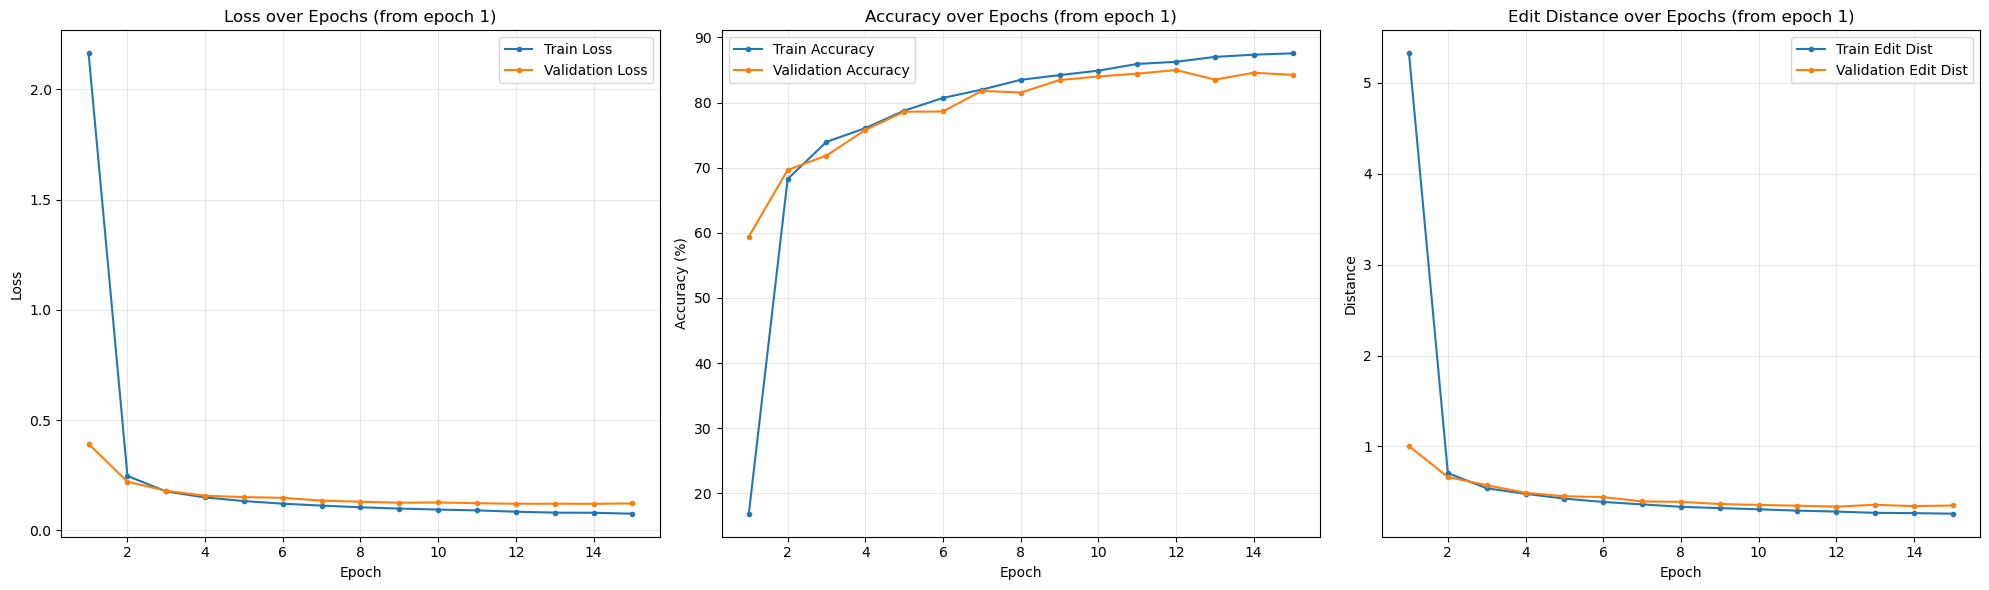

In [16]:
# Visualization (Metrics)
plot_training_metrics(checkpoint_path)

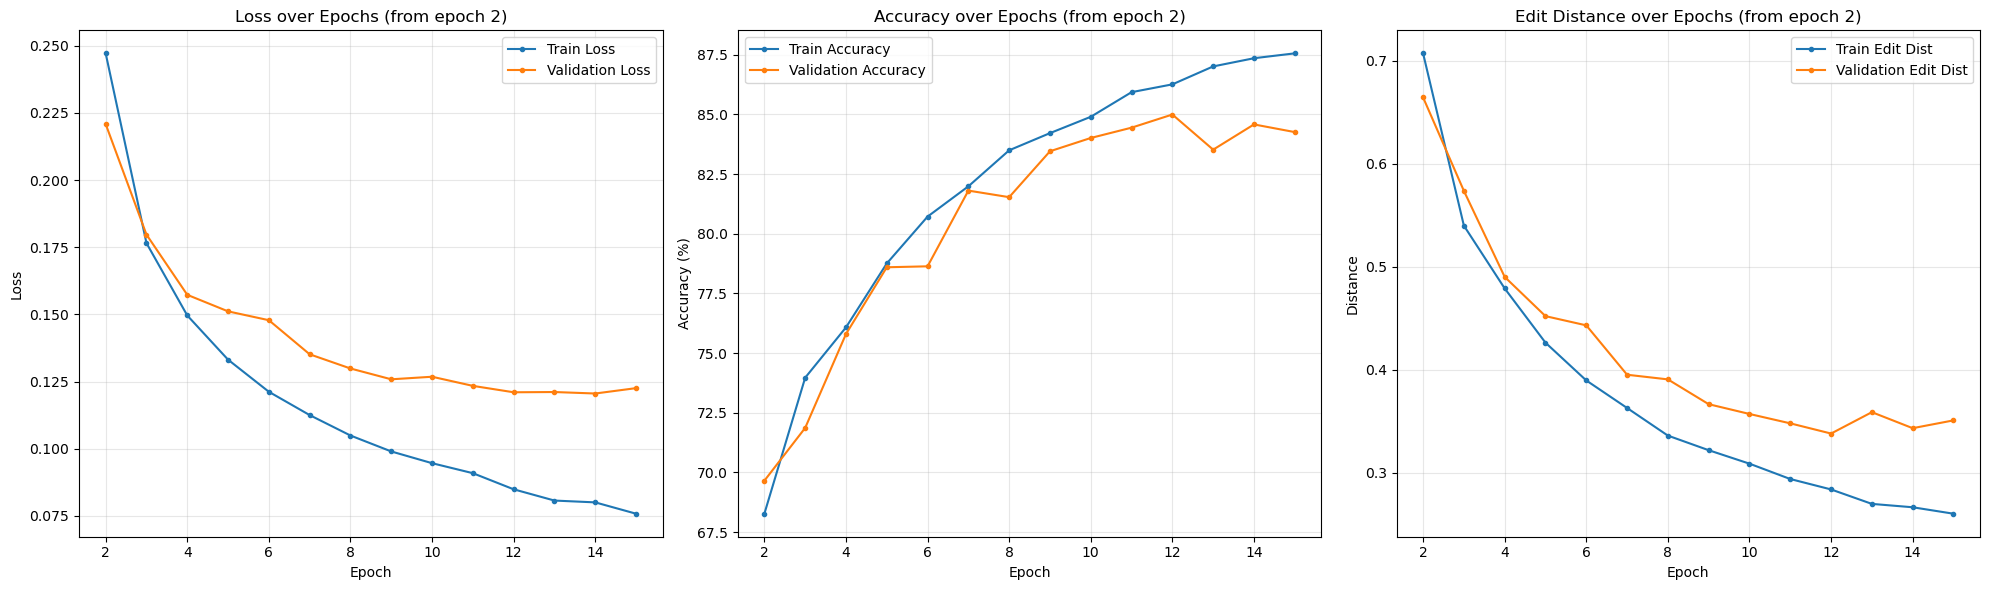

In [17]:
# 초반 epoch에서 높은 수치에서 급감하거나 급등하는 현상으로
# 그 이후 epoch의 변화의 양상이 잘 보이지 않기에, x축을 조절해서 보기 위해 진행
plot_training_metrics(checkpoint_path, start_epoch=2)

# 5. 모델 추론 테스트 (Inference)

In [11]:
# Load Best Model
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    
    # 모델 재초기화 (변수가 덮어씌워졌을 경우를 대비)
    num_chars = len(label_converter.character)
    model = CRNN(num_chars=num_chars).to(device)
    
    model.load_state_dict(torch.load(best_model_path))
else:
    print(f"No best model found at {best_model_path}")

Loading best model from /home/jovyan/work/project/GoingDeeper/Quest06/model/best_model.pth


In [12]:
test_model(model, test_loader, label_converter, device)

Testing:   0%|          | 0/175 [00:00<?, ?it/s]


=== Test Result ===
Total samples   : 89192
Accuracy        : 84.49% (75354/89192)
Avg Edit Dist   : 0.343
Avg CTC Loss    : 1.4119


{'accuracy': 84.48515561933806,
 'avg_edit_distance': 0.34309130863754594,
 'avg_loss': 1.4118531131564753,
 'total_samples': 89192}

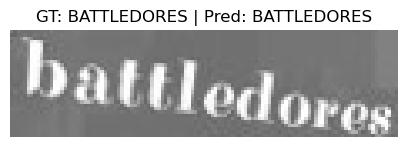

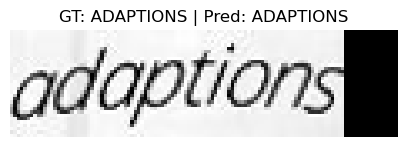

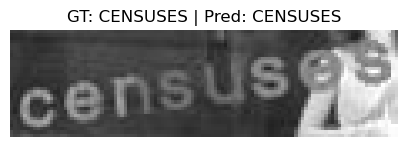

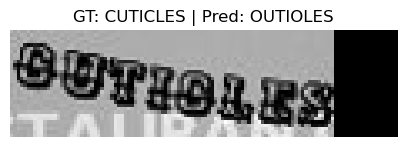

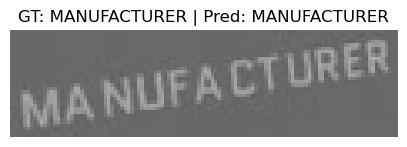

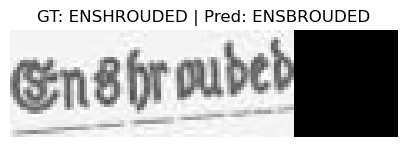

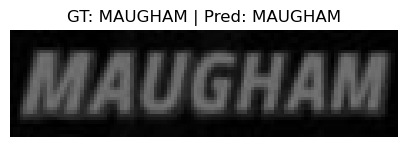

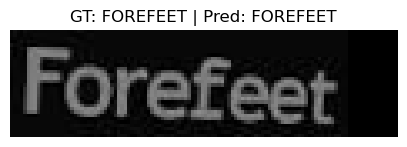

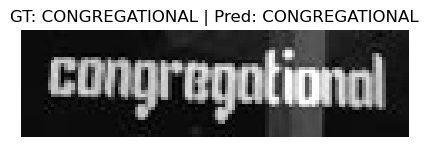

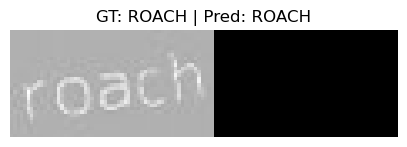

In [8]:
# Inference Check
check_inference(model, test_dataset, label_converter, device, num_samples=10)

# 6. EasyOCR을 이용한 텍스트 검출 및 CRNN 인식 (End-to-End)

Detecting text...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

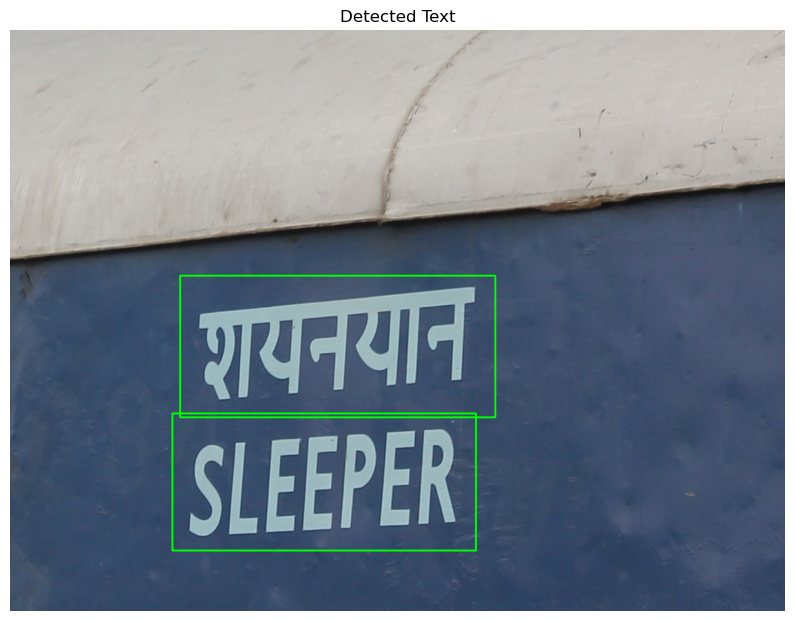

Recognizing text...


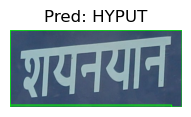

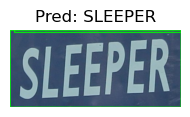


Recognition Results:
- HYPUT
- SLEEPER


In [19]:
# End-to-End OCR

# Download sample image if not exists
sample_img_path = "data/sample.jpg"
if not os.path.exists(sample_img_path):
    !wget -O sample.jpg https://d3s0tskafalll9.cloudfront.net/media/original_images/sample.jpg

# 1. Detect Text
print("Detecting text...")
img_vis, cropped_imgs, ocr_result = detect_text(sample_img_path)

# Visualize Detection
plt.figure(figsize=(10, 10))
plt.imshow(img_vis)
plt.axis('off')
plt.title("Detected Text")
plt.show()

# 2. Recognize Text
print("Recognizing text...")
recognized_texts = recognize_img(model, cropped_imgs, label_converter, device)

print("\nRecognition Results:")
for text in recognized_texts:
    print(f"- {text}")